Сегодня побалуемся с датасетом, в котором нужно предсказывать цену автомобиля по его параметрам. Посмотрим, как работают Lasso и Ridge, как можно нормализовать данные и как собрать это все в ПАЙПЛАЙН!

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('Car details v3.csv')
data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [3]:
data.dtypes

name              object
year               int64
selling_price      int64
km_driven          int64
fuel              object
seller_type       object
transmission      object
owner             object
mileage           object
engine            object
max_power         object
torque            object
seats            float64
dtype: object

Окей, видим, что у нас не так много числовых фич, зато часть строчных можно превратить в числовые. Но сперва надо проверить, есть ли у нас наны, и дропнуть их. 

In [ ]:
# your code here

Посмотрели? Дропнем и сравним, сколько у нас осталось данных (сперва посмотрите длину целого датасета)

In [ ]:
# your code here

Теперь можем что-то сделать с engine и maxpower: кажется, что у них достаточно отрезать единицы измерения

In [5]:
data['engine'] = data['engine'].apply(lambda s: float(s[:-3]))
data['max_power'] = data['max_power'].apply(lambda s: float(s[:-4]))
data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248.0,74.00,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498.0,103.52,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497.0,78.00,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396.0,90.00,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298.0,88.20,"11.5@ 4,500(kgm@ rpm)",5.0


Отлично. Но это еще не все, что можно сделать. (Заметка: mileage лучше оставить, там какие-то разные единицы измерения)

Можем позырить, что у нас в transmission, seller_type и fuel.

In [6]:
print(data['fuel'].unique())
print(data['transmission'].unique())
print(data['seller_type'].unique())

['Diesel' 'Petrol' 'LPG' 'CNG']
['Manual' 'Automatic']
['Individual' 'Dealer' 'Trustmark Dealer']


Кажется, заменить transmission на циферки - нет ничего легче. А вот с seller_type и fuel понадобится one hot encoding (а вы знаете, что это такое?)

In [ ]:
# замените transmission

In [8]:
data = pd.get_dummies(data, columns = ['seller_type', 'fuel'], drop_first=True)
data.head()

,name,year,selling_price,km_driven,transmission,owner,mileage,engine,max_power,torque,seats,seller_type_Individual,seller_type_Trustmark Dealer,fuel_Diesel,fuel_LPG,fuel_Petrol
0,Maruti Swift Dzire VDI,2014,450000,145500,1,First Owner,23.4 kmpl,1248.0,74.00,190Nm@ 2000rpm,5.0,1,0,1,0,0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,1,Second Owner,21.14 kmpl,1498.0,103.52,250Nm@ 1500-2500rpm,5.0,1,0,1,0,0
2,Honda City 2017-2020 EXi,2006,158000,140000,1,Third Owner,17.7 kmpl,1497.0,78.00,"12.7@ 2,700(kgm@ rpm)",5.0,1,0,0,0,1
3,Hyundai i20 Sportz Diesel,2010,225000,127000,1,First Owner,23.0 kmpl,1396.0,90.00,22.4 kgm at 1750-2750rpm,5.0,1,0,1,0,0
4,Maruti Swift VXI BSIII,2007,130000,120000,1,First Owner,16.1 kmpl,1298.0,88.20,"11.5@ 4,500(kgm@ rpm)",5.0,1,0,0,0,1


Как вы думаете, для чего drop_first? как это работает? Как ни странно, но некоторая параллель есть в фонологии (в том месте, где они ограничиваются бинарными признаками)

А, еще осталось owner заменить. Тут можно накатать небольшую функцию 

In [9]:
data['owner'].unique()

array(['First Owner', 'Second Owner', 'Third Owner',
       'Fourth & Above Owner', 'Test Drive Car'], dtype=object)

In [ ]:
def replacer(string):
    # your code here

data['owner'] = data['owner'].apply(replacer)

Окей, вроде бы готово. Давайте попробуем загнать линейную регрессию. 

In [11]:
y = data['selling_price']
X = data.drop(['selling_price', 'name', 'mileage', 'torque'], axis=1)

In [12]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

In [13]:
model = LinearRegression()

model.fit(Xtrain, ytrain)

ypred_train = model.predict(Xtrain)
ypred_test = model.predict(Xtest)

print(r2_score(ytrain, ypred_train), r2_score(ytest, ypred_test))

0.6649295201316685 0.616876259960565


Можем из интереса посмотреть веса:

In [14]:
for a,b in zip(X.columns, model.coef_):
    print(a,b)

year 43242.499176324534
km_driven -0.9975230888867888
transmission 7.73070496506989e-12
owner -15194.006030781047
engine 61.126941271723695
max_power 15048.309449061167
seats -80414.79482723569
seller_type_Individual -346027.1715962796
seller_type_Trustmark Dealer -354875.62862594816
fuel_Diesel -76024.71436525947
fuel_LPG 135154.27256726995
fuel_Petrol -125199.85363468408


Можно даже вискербокс построить

{'whiskers': [<matplotlib.lines.Line2D at 0x7fedb66d7b20>,
 'caps': [<matplotlib.lines.Line2D at 0x7fedb66f41c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fedb66d76d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fedb66f4910>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fedb66f4ca0>],
 'means': []}

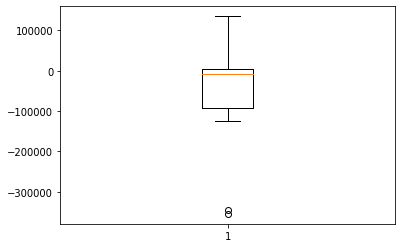

In [15]:
plt.boxplot(model.coef_)

Фиг знает, поможет ли нам, но почему бы не попробовать нормализовать данные? Зачем их вообще нормализовать? Немного отвлечемся от нашего датасета и посмотрим чужой, а заодно и глянем на классификацию - как правило, нормализация важнее там)

In [16]:
X1 = pd.read_csv('scaler_example.csv')
X1.head()

,Unnamed: 0,lat,lon,class
0,0,55.718427,37.572628,1
1,1,55.718749,37.573061,1
2,2,55.719072,37.573495,1
3,3,55.719394,37.573928,1
4,4,55.719717,37.574361,1


Посмотрим, как выглядят точки из датасета. 

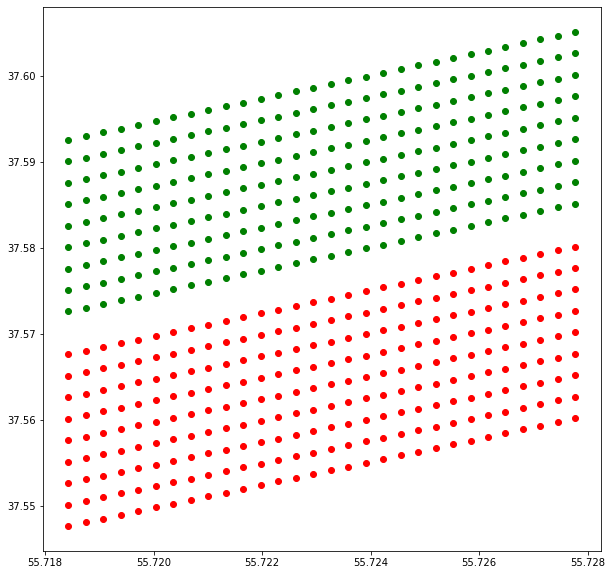

In [17]:
Xtrain1 = X1[['lat','lon']].values
Ytrain1 = X1['class'].values

figure(figsize=(10,10))
scatter(Xtrain1[Ytrain1==1][:,0],Xtrain1[Ytrain1==1][:,1],color='green')
scatter(Xtrain1[Ytrain1==0][:,0],Xtrain1[Ytrain1==0][:,1],color='red')

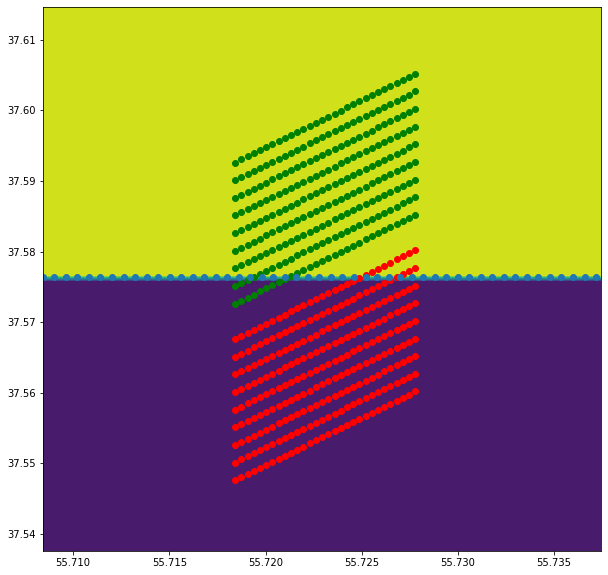

In [18]:
from sklearn.svm import SVC

clf = SVC(kernel='linear')
clf.fit(Xtrain1,Ytrain1)

def plot_decision_line(Xtrain, Ytrain, clf, h):

    x_min, x_max = Xtrain[:,0].min()-0.01, Xtrain[:,0].max()+0.01
    y_min, y_max = Xtrain[:,1].min()-0.01, Xtrain[:,1].max()+0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(10,10))
    plt.contourf(xx, yy, Z)

    Ytrain = np.array(Ytrain)
    plt.scatter(Xtrain[Ytrain==1][:,0],Xtrain[Ytrain==1][:,1],color='green')
    plt.scatter(Xtrain[Ytrain==0][:,0],Xtrain[Ytrain==0][:,1],color='red')

    a = clf.coef_[0][0]
    b = clf.coef_[0][1]
    c = clf.intercept_

    K = -a*1./b
    B = -c*1./b

    xx0 = np.linspace(x_min, x_max)
    yy0 = K * xx0 + B

    plt.scatter(xx0,yy0)
    plt.show()
    
plot_decision_line(Xtrain1, Ytrain1, clf, 0.001)

Видим, что линейный классификатор (SVM) абсолютно не справился с задачей. Попробуем масштабировать данные.

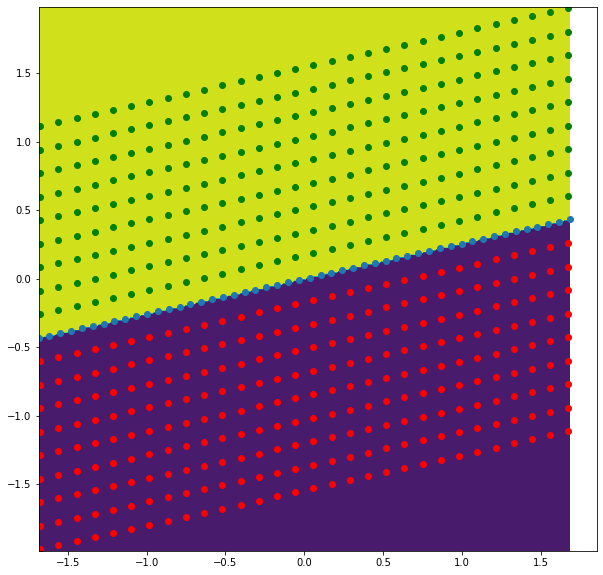

In [19]:
sc = StandardScaler()
TrainScaled = sc.fit_transform(Xtrain1)

clf.fit(TrainScaled,Ytrain1)
plot_decision_line(TrainScaled, Ytrain1, clf, 0.01)

Тадам. Не факт, что для нашего датасета нормализация поможет, но.

In [20]:
scaler = StandardScaler().fit(Xtrain)
Xtrain = scaler.transform(Xtrain)
Xtest = scaler.transform(Xtest)

regressor = LinearRegression()
regressor.fit(Xtrain, ytrain)

ypred_train = regressor.predict(Xtrain)
ypred_test = regressor.predict(Xtest)
print(r2_score(ytrain, ypred_train), r2_score(ytest, ypred_test))

0.6649295201316685 0.6168762599605502


Вроде сильно не помогло, но мы старались

Можем попробовать другой скейлер

In [21]:
scaler = MinMaxScaler().fit(Xtrain)
Xtrain = scaler.transform(Xtrain)
Xtest = scaler.transform(Xtest)

regressor = LinearRegression()
regressor.fit(Xtrain, ytrain)

ypred_train = regressor.predict(Xtrain)
ypred_test = regressor.predict(Xtest)
print(r2_score(ytrain, ypred_train), r2_score(ytest, ypred_test))

0.6649295201316685 0.6168762599605506


Ну лан

Заметьте, что все скейлеры импортируются из подмодуля preprocessing, там есть еще кой-че

А еще вот это вот все можно взять и собрать в пайплайн, то есть, любые трансформации, которые мы применяем к данным, помимо модели, можно собрать в конвейер. При условии, что у них всех есть одинаковые методы (fit, predict)

In [22]:
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('model', LinearRegression())
])

Теперь это говно можно обучать, как обычную модель

In [23]:
pipe.fit(Xtrain, ytrain)

ypred_train = pipe.predict(Xtrain)
ypred_test = pipe.predict(Xtest)
print(r2_score(ytrain, ypred_train), r2_score(ytest, ypred_test))

0.6649295201316684 0.6168762599605506


Алсо, можно запилить функцию, в которую уже передавать имена моделек и гонять сколько хочется

In [24]:
def pipeliner(model):
    pipe = Pipeline([
    ('scale', StandardScaler()),
    ('model', model)
])
    pipe.fit(Xtrain, ytrain)

    ypred_train = pipe.predict(Xtrain)
    ypred_test = pipe.predict(Xtest)
    print(r2_score(ytrain, ypred_train), r2_score(ytest, ypred_test))

In [25]:
pipeliner(LinearRegression())
pipeliner(Lasso())
pipeliner(Ridge())

0.6649295201316684 0.6168762599605506
0.6649295199542795 0.6168768992723096
0.664929481001288 0.6169074312947878


Можно заметить, что нормализация скейлером нивелирует почти всю разницу между лассо, риджем и обычным линрегом. Она так действует не только для них.

Кстати, попробуйте погонять лассо и ридж на ненормализованных данных. Будет ли сильная разница? Почему?

In [ ]:
# your code here

Ну ок, наверное, если хотим рили улучшить качество модельки, надо все-таки фиче-инжинирингом заняться. Давайте посмотрим корреляцию признаков

<AxesSubplot:>

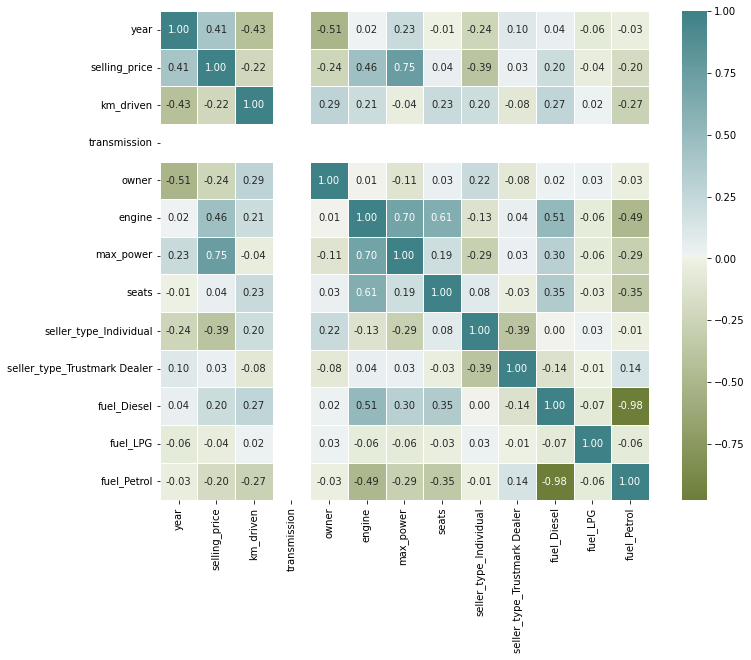

In [26]:
plt.figure(figsize=(12,9))

corr = data.corr()

sns.heatmap(corr,annot=True,linewidths=.5,fmt= '.2f',\
            mask=np.zeros_like(corr, dtype=bool), \
            cmap=sns.diverging_palette(100,200,as_cmap=True), square=True)

Таки что вы можете сказать по этому поводу? Выделите графу с selling_price и проанализируйте, с каким признаком она больше всего коррелирует. Посмотрите, нет ли линейно-зависимых признаков (они будут коррелировать между собой).

Какие признаки можно дропнуть? Может быть, стоит добавить какой-то признак в степени? Попробуйте это сделать

In [ ]:
# your code here